In [12]:
from dotenv import load_dotenv

# Load .env file
load_dotenv()

True

In [1]:
# Testing langsmith with OpenAI
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BmexxTppKygU9rdRvmBYqJ3nKpSNU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--32d2fbee-0de3-4a9a-99d8-f9643bbf89f2-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [14]:
# `Annotated` is used to add metadata or annotations to types
# In LangGraph, it's used to tell the system how a field (like 'messages') should be updated
# For example, combining `list` with `add_messages` means: "this is a list, and when new values come, append to it instead of replacing"
from typing import Annotated

# Importing TypedDict from typing_extensions to define a custom dictionary-like type with fixed keys and value types
from typing_extensions import TypedDict

# Importing StateGraph and START from langgraph.graph
# - StateGraph is used to define a graph-based computational workflow
# - START is a predefined constant representing the starting node in the graph
from langgraph.graph import StateGraph, START

# Importing add_messages from langgraph.graph.message
# This function is used to define how new messages should be added to the graph state.
from langgraph.graph.message import add_messages


# Defining the state for our graph using a TypedDict
# This is a structure that defines what kind of data our state will carry
class State(TypedDict):
    # The state has one key: `messages`, which holds a list
    # The `Annotated` part (not shown here but expected to be imported from typing) is used to attach metadata
    # Specifically, `add_messages` tells the framework how to update the list:
    # it appends new messages to the existing list, rather than replacing it
    messages: Annotated[list, add_messages]


# Creating a graph builder object using the defined state
# This object is used to define and build a LangGraph computation graph using the `State` structure
graph_builder = StateGraph(State)



    Each node can receive the current State as input and output an update to the state.
    Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.


When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.

In [15]:
# Testing langsmith with OpenAI
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
llm.invoke("Hello, world!")

AIMessage(content='Hello there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BmO2b6u8FVNe0ngwb5VUm0LucU0z9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d449258a-f791-45bd-9d66-fd38c56c011a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [16]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the LLM's response messages to whatever messages are already in the state.

In [17]:
graph_builder.add_edge(START, "chatbot")

In [18]:
graph = graph_builder.compile()

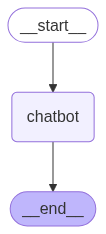

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Run the chatbot

In [20]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


# Assignment
Try to create a graph with two chatbot

In [21]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

# Define state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Connect the state with stategraph
graph_builder = StateGraph(State)

# Define LLMs
llm1 = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm2 = ChatOpenAI(temperature=1)

# Define functions
def chatbot1(state: State):
    return {"messages": [llm1.invoke(state["messages"])]}

def chatbot2(state: State):
    return {"messages": [llm2.invoke(state["messages"])]}

# Add nodes
graph_builder.add_node("chatbot1", chatbot1) 
graph_builder.add_node("chatbot2", chatbot2) 

# Add edge
graph_builder.add_edge(START, "chatbot1")
graph_builder.add_edge("chatbot1", "chatbot2")
graph = graph_builder.compile()

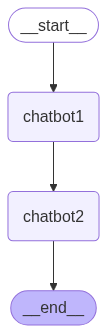

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break